In [1]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

In [2]:
import os

img_dir = "C:/Users/kaiqu/lamia-projeto-final/dogbreed/images/Images/"

breed_list = os.listdir(img_dir)
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    breed_path = os.path.join(img_dir, breed)
    n_total_images += len(os.listdir(breed_path))
print("{} images".format(n_total_images))


120 breeds
20580 images


In [3]:
label_maps = {}
label_maps_rev = {}

# cria um dicionário de mapeamento de rótulos
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [4]:
def show_dir_images(breed, N):
    img_dir = os.path.join("C:/Users/kaiqu/lamia-projeto-final/dogbreed/images/Images", breed)
    images = [f for f in os.listdir(img_dir)] # itera por todas as imagens da pasta

    # quantas imagens mostrar
    images = images[:N]

    # calcula o número de linhas com base nas imagens por linha (por exemplo, 4 imagens por linha)
    rows = (N - 1) // 4 + 1

    for i, image_name in enumerate(images):
        img_path = os.path.join(img_dir, image_name)
        img = mpimg.imread(img_path)
        plt.subplot(rows, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

n02093256-Staffordshire_bullterrier


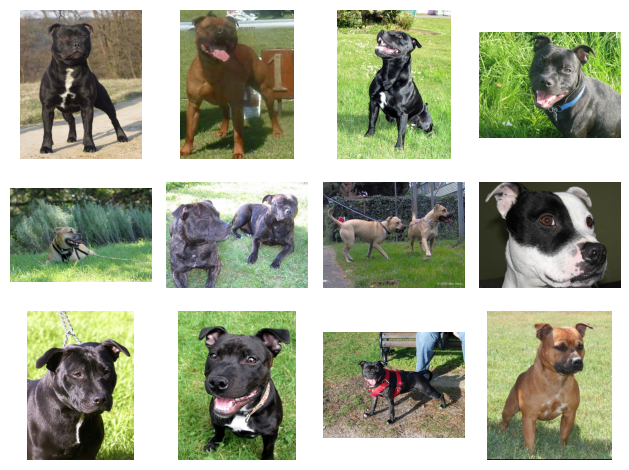

In [5]:
breed_num = 28
print(breed_list[breed_num])
show_dir_images(breed_list[breed_num], 12)

In [6]:
img_size = 128
batch_size = 32

train = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode ="categorical"
)

val = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [29]:
inp = Input((128, 128, 3))
base_model = DenseNet121(input_tensor=inp, weights="imagenet", include_top=False)
base_model.trainable = False

x = data_augmentation(inp)
x = base_model(x)
x = GlobalAveragePooling2D()(x) # sempre após o modelo pré-treinado
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(120, activation="softmax")(x)

model = Model(inp, outp)

In [30]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [31]:
model_name = "model.h5"
monitor = 'val_loss'

checkpoint = ModelCheckpoint(
    model_name,
    monitor = monitor,
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

early_stopping = EarlyStopping(
    monitor = monitor,
    patience =5,
    restore_best_weights =True,
    verbose =1
    )

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(
    monitor = monitor,
    factor =0.2,
    patience =3,
    min_lr =0.0001)


In [32]:
history = model.fit_generator(train, epochs=30, validation_data=val, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/30


515/515 [==============================] - ETA: 0s - loss: 4.3470 - acc: 0.0698
Epoch 1: val_loss improved from -inf to 2.67264, saving model to model.h5
515/515 [==============================] - 111s 197ms/step - loss: 4.3470 - acc: 0.0698 - val_loss: 2.6726 - val_acc: 0.3326 - lr: 0.0010
Epoch 2/30
515/515 [==============================] - ETA: 0s - loss: 3.4426 - acc: 0.1738
Epoch 2: val_loss did not improve from 2.67264
515/515 [==============================] - 89s 173ms/step - loss: 3.4426 - acc: 0.1738 - val_loss: 2.1985 - val_acc: 0.4225 - lr: 0.0010
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 3.1717 - acc: 0.2222
Epoch 3: val_loss did not improve from 2.67264
515/515 [==============================] - 98s 191ms/step - loss: 3.1717 - acc: 0.2222 - val_loss: 2.0214 - val_acc: 0.4706 - lr: 0.0010
Epoch 4/30
515/515 [==============================] - ETA: 0s - loss: 3.0064 - acc: 0.2478
Epoch 4: val_loss did not improve from 2.67264
515/515 [===========

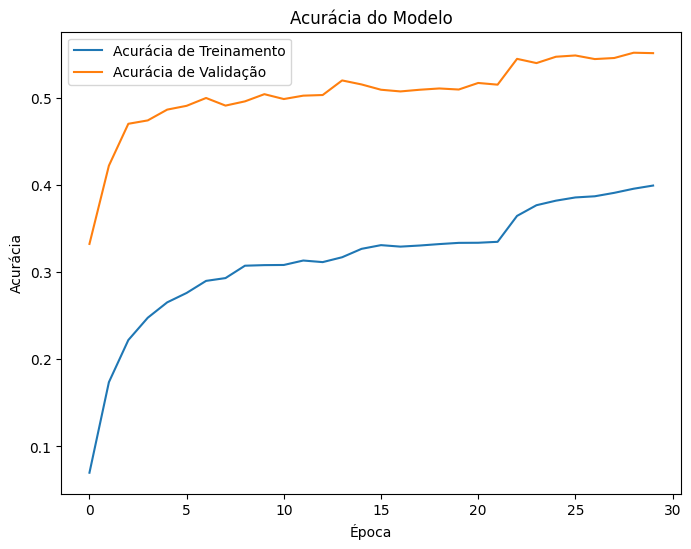

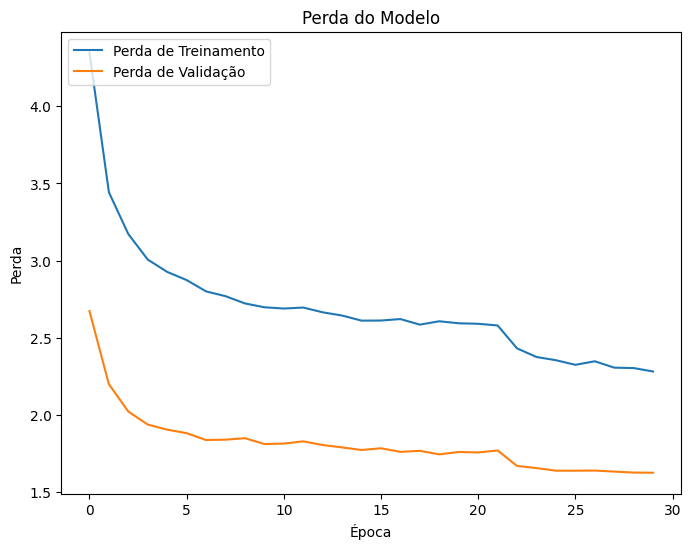

In [36]:
# Plot de Acurácia
plt.figure(figsize=(8, 6))
plt.plot(history.history['acc'], label='Acurácia de Treinamento')
plt.plot(history.history['val_acc'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()

# Plot de Perda
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper left')
plt.show()

129/129 [==============================] - 5s 36ms/step
Matriz de Confusão:
[[0 0 1 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 3 0]
 ...
 [0 1 0 ... 0 1 1]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 1 0 1]]


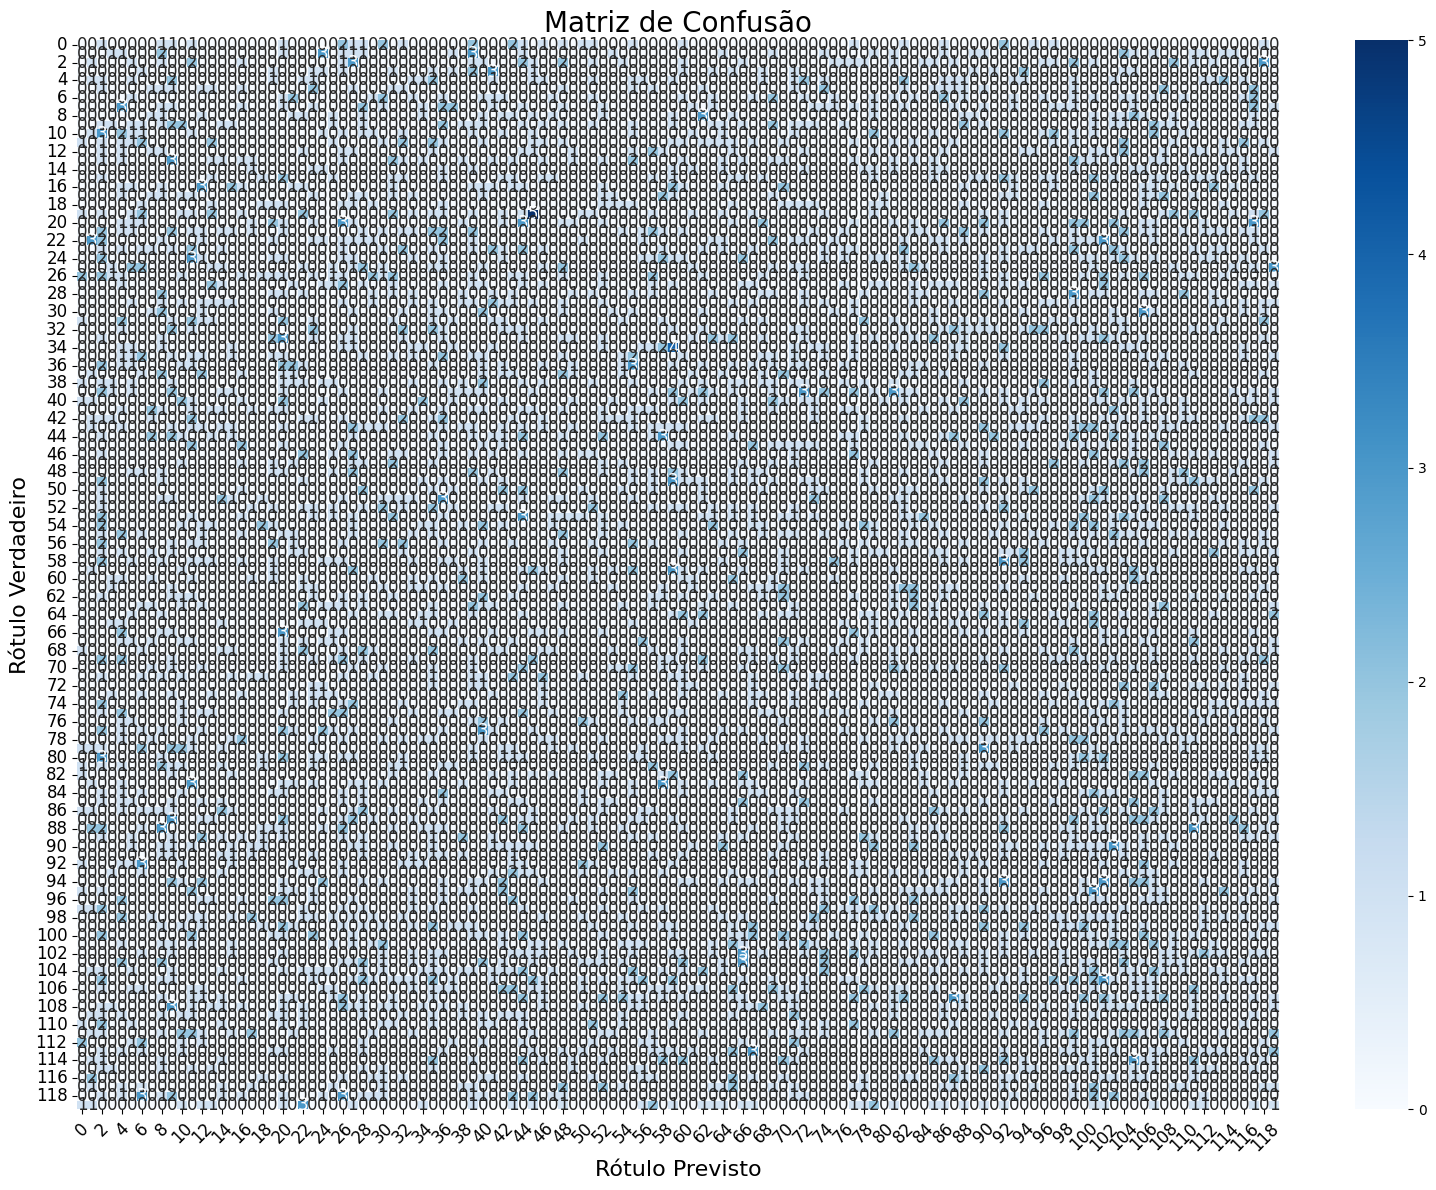

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        42
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        38
           7       0.00      0.00      0.00        38
           8       0.02      0.03      0.03        30
           9       0.04      0.04      0.04        46
          10       0.00      0.00      0.00        34
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        31
          13       0.04      0.03      0.03        39
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        36
          16       0.04      0.03      0.04        33
          17       0.00    

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(val)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in val], axis=0)
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred_labels)
print("Matriz de Confusão:")
print(cm)

# Plote a matriz de confusão com uma figura maior e fontes ajustadas
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Rótulo Previsto', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=16)
plt.title('Matriz de Confusão', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_labels))


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def img_predict(filename):
    # Carregar e redimensionar a imagem com PIL
    img = Image.open(filename).convert('RGB')
    img = img.resize((128, 128))

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Converter para array e pré-processar
    img = np.array(img, dtype='float32')
    img = preprocess_input(img)

    # Fazer a predição (supondo que 'model' já esteja carregado)
    probs = model.predict(np.expand_dims(img, axis=0))

    # Exibe as 5 raças mais prováveis
    for idx in probs.argsort()[0][::-1][:5]:
        print(f"{probs[0][idx]*100:.2f}%\t", label_maps_rev[idx].split("-")[-1])

    print("Probabilidade máxima:", probs.max())


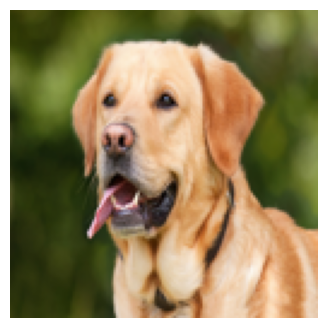

1/1 [==============================] - 0s 40ms/step
3.90%	 Italian_greyhound
3.77%	 Chihuahua
2.98%	 Saluki
2.86%	 dhole
2.55%	 Chesapeake_Bay_retriever
Probabilidade máxima: 0.039005287


In [28]:
img_predict('test_5.jpg')